In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential

In [3]:
weather_df = pd.read_csv('data 2002-2022.csv')
weather_df.head()

,WS2M,PRECTOTCORR,ALLSKY_SFC_PAR_TOT,CLRSKY_SFC_PAR_TOT,WS10M,ALLSKY_SFC_SW_DWN,TS,T2M,WS50M,PS,QV2M,ALLSKY_SFC_UV_INDEX
0,2.40,13.17,13.59,51.30,3.85,0.68,11.93,12.37,6.08,100.51,8.48,0.16
1,2.36,23.63,17.01,51.95,3.89,0.86,11.11,11.72,5.98,100.53,8.36,0.20
2,1.61,0.27,50.47,55.61,2.41,2.81,8.72,9.56,3.30,101.33,6.59,0.43
3,1.59,0.14,46.89,53.30,2.47,2.63,7.76,8.15,3.44,101.39,5.74,0.42
4,1.80,11.64,21.77,54.66,2.73,1.11,9.55,9.66,4.12,101.56,6.96,0.24


In [4]:
weather_df.shape

(7609, 12)

In [5]:
weather_df.isnull().any()

WS2M                   False
PRECTOTCORR            False
ALLSKY_SFC_PAR_TOT     False
CLRSKY_SFC_PAR_TOT     False
WS10M                  False
ALLSKY_SFC_SW_DWN      False
TS                     False
T2M                    False
WS50M                  False
PS                     False
QV2M                   False
ALLSKY_SFC_UV_INDEX    False
dtype: bool

In [6]:
X = weather_df.loc[:,['QV2M', 'PS', 'WS50M','T2M','TS','ALLSKY_SFC_SW_DWN','WS10M','ALLSKY_SFC_UV_INDEX','CLRSKY_SFC_PAR_TOT','ALLSKY_SFC_PAR_TOT','WS2M']]
Y = weather_df.loc[:,'PRECTOTCORR']

X_train, X_test,Y_train, Y_test=train_test_split(X,Y, test_size=0.2,random_state=100)
mean=X.mean()
std=X.std()
X_train_n=(X_train-mean)/std
X_test_n=(X_test-mean)/std
X_train_n.head()

,QV2M,PS,WS50M,T2M,TS,ALLSKY_SFC_SW_DWN,WS10M,ALLSKY_SFC_UV_INDEX,CLRSKY_SFC_PAR_TOT,ALLSKY_SFC_PAR_TOT,WS2M
7211,-0.281101,-0.234893,-0.129269,0.940440,1.066222,0.472023,-0.111038,0.229604,0.169346,0.270289,-0.049417
7552,-0.038044,-1.731955,-0.675209,3.733371,3.153930,0.826057,-0.872855,-4.355277,-5.393271,-5.393178,-1.101720
2549,-0.409380,-1.710259,2.555470,-1.128805,-1.151124,-1.789864,2.480891,0.224837,-0.108312,-0.159517,2.515572
5370,0.873416,0.481094,-0.938545,0.794602,0.806946,0.771968,-0.960420,0.230887,0.227041,0.324399,-0.996490
3144,0.826155,-0.451858,0.121221,0.247023,0.463947,-0.221295,0.353057,0.230841,0.361141,0.172163,0.437273


In [7]:
print(X_train.shape)
print(X_test.shape)

(6087, 11)
(1522, 11)


In [8]:
X.shape

(7609, 11)

In [9]:
X.columns

Index(['QV2M', 'PS', 'WS50M', 'T2M', 'TS', 'ALLSKY_SFC_SW_DWN', 'WS10M',
       'ALLSKY_SFC_UV_INDEX', 'CLRSKY_SFC_PAR_TOT', 'ALLSKY_SFC_PAR_TOT',
       'WS2M'],
      dtype='object')

In [10]:
# Define basic architecture
model = keras.Sequential([
    keras.layers.Dense(256, activation=tf.nn.relu, #activation=tf.keras.activations.linear,
                       input_shape=(X_train.shape[1],),
                       name='hidden_layer_1',),
    keras.layers.Dense(256, activation=tf.nn.relu,
                       name='hidden_layer_2',),
    keras.layers.Dense(1, name='output_layer',)
])

model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(),metrics=['mae'])
# Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 256)               3072      
                                                                 
 hidden_layer_2 (Dense)      (None, 256)               65792     
                                                                 
 output_layer (Dense)        (None, 1)                 257       
                                                                 
Total params: 69,121
Trainable params: 69,121
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')
        
# Visualize the model's training progress using the stats stored in the history object. 
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()
    #plt.ylim([0, 5])


...........................................................................

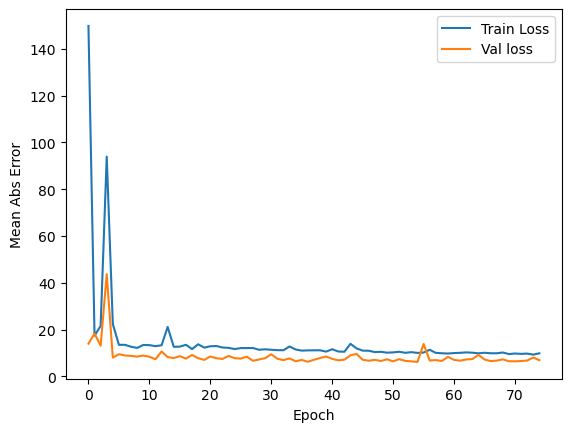

In [12]:
# Over-fitting?
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# Store training stats
history = model.fit(X_train, Y_train, epochs=1000,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])
plot_history(history)

In [13]:
[loss, mae] = model.evaluate(X_test_n, Y_test, verbose=0)

print(f'The mean absolute Error is {mae}.')

The mean absolute Error is 1.8981930017471313.


48/48 [==============================] - 0s 792us/step


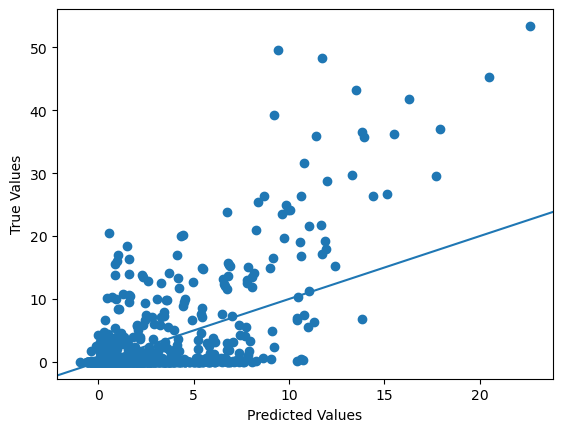

In [14]:
Y_predict = model.predict(X_test_n)

plt.scatter(Y_predict, Y_test)
plt.xlabel('Predicted Values')
plt.ylabel('True Values')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.plot([-100,100],[-100,100])

In [15]:
from sklearn.metrics import r2_score
r2_score(Y_test,Y_predict)

0.4300823297963028

In [16]:
from sklearn.metrics import mean_squared_error
# Calculation of Mean Squared Error (MSE)
mean_squared_error(Y_test,Y_predict)

16.27706481002985

In [17]:
import math
RMSE = math.sqrt(17.419797503510935)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

4.173703092400193


In [18]:

from sklearn.metrics import mean_absolute_error as mae


error = mae(Y_test, Y_predict)

print("Mean absolute error : " + str(error))


Mean absolute error : 1.8981931719974996


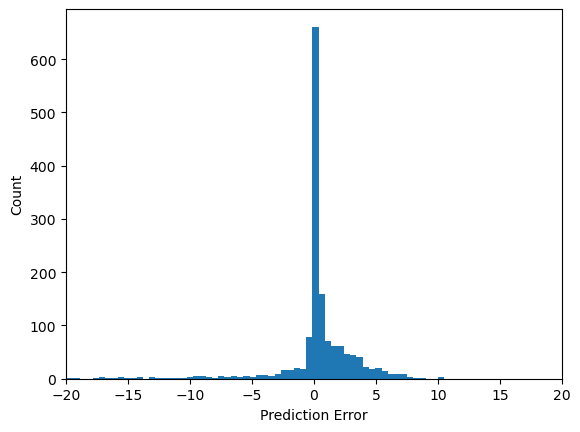

In [19]:
error = Y_predict.reshape(1522,) - Y_test
plt.xlim(-20,20)
plt.hist(error,bins = 100)
plt.xlabel("Prediction Error")
plt.ylabel("Count")
_=plt.ylabel("Count")
